<h1 style="text-align:center; color:green; font-size:48px;">
Step 2: Heating Network Expansion
</h1>

#### Install libraries (if you did not do it before on the terminal)

In [173]:
# !pip install numpy==2.0.2 pandas==2.3.1
# !pip install matplotlib
# !pip install git+https://github.com/oemof/dhnx.git@dev
# !pip install osmnx==1.9.4 oemof.solph==0.5.6

# Import libraries

In [174]:
import matplotlib.pyplot as plt
import dhnx
import pandas as pd
import oemof.solph
from pyomo.environ import SolverFactory


## 2.1 Create network and plot

In [175]:
# Initialize thermal network
network = dhnx.network.ThermalNetwork()

# Load town parameter
network = network.from_csv_folder(r"STEP_2/twn_data")
    
# Load investment parameter
invest_opt = dhnx.input_output.load_invest_options(r"STEP_2/invest_data")

No sequences found to create timeindex from


In [176]:
print(network)

dhnx.network.ThermalNetwork object with these components
 * 5 producers
 * 10 consumers
 * 8 forks
 * 28 pipes



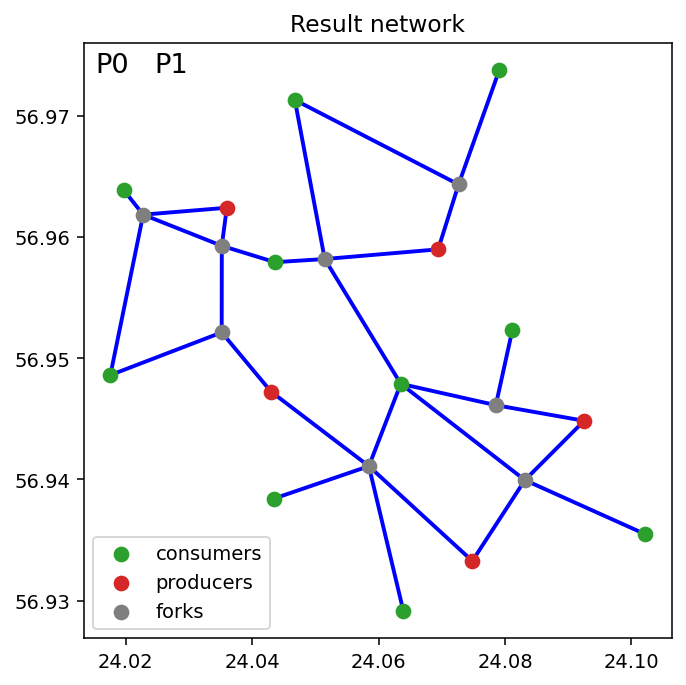

In [177]:
# plot invested edges
plt.rcParams['figure.figsize'] = (10, 8)   # <-- bigger
plt.rcParams['figure.dpi'] = 140

static_map_1 = dhnx.plotting.StaticMap(network)
static_map_1.draw(background_map=False)
ax = plt.gca()
ax.set_title('Result network')

# Scatter points
plt.scatter(network.components.consumers['lon'], network.components.consumers['lat'],
            color='tab:green', label='consumers', zorder=2.5, s=50)
plt.scatter(network.components.producers['lon'], network.components.producers['lat'],
            color='tab:red', label='producers', zorder=2.5, s=50)
plt.scatter(network.components.forks['lon'], network.components.forks['lat'],
            color='tab:grey', label='forks', zorder=2.5, s=50)

# labels that DON'T expand the axis extent
plt.text(0.02, 0.95, 'P0', transform=ax.transAxes, fontsize=14)
plt.text(0.12, 0.95, 'P1', transform=ax.transAxes, fontsize=14)

plt.legend()
plt.tight_layout()
plt.show()

## 2.2 Investment optimization of the network

In [178]:
# Optimize the investment data
# Check available solvers and use an appropriate one
available_solvers = ['cbc', 'gurobi', 'cplex']
solver_to_use = None

for solver in available_solvers:
	if SolverFactory(solver).available():
		solver_to_use = solver
		print(f"Using solver: {solver}")
		break

if solver_to_use is None:
	raise Exception("No suitable solver found. Please install glpk or cbc.")

try:
	network.optimize_investment(invest_options=invest_opt, solver=solver_to_use)
except ValueError as e:
	print("Optimization failed with ValueError:", e)
	# Reset any existing investment/capacity columns on pipes that may cause conflicts
	if 'pipes' in network.components and hasattr(network.components['pipes'], 'columns'):
		pipes_df = network.components['pipes']
		if 'investment' in pipes_df.columns:
			pipes_df['investment'] = 0
		if 'capacity' in pipes_df.columns:
			pipes_df['capacity'] = 0
		network.components['pipes'] = pipes_df

	# Try again once after resetting
	try:
		network.optimize_investment(invest_options=invest_opt, solver=solver_to_use)
	except Exception as e2:
		# surface the original and the retry failure
		print("Retry failed:", e2)
		raise


INFO:dhnx.optimization.optimization_models:Initialize the energy system
INFO:dhnx.optimization.optimization_models:Create oemof objects
INFO:dhnx.optimization.optimization_models:Producers, Consumers Nodes appended.
/opt/anaconda3/envs/env_P2/lib/python3.9/site-packages/oemof/solph/flows/_flow.py:163: FutureWarning: For backward compatibility, the option investment overwrites the option nominal_value. Both options cannot be set at the same time.
  warn(msg, FutureWarning)
/opt/anaconda3/envs/env_P2/lib/python3.9/site-packages/oemof/network/network/nodes.py:250: FutureWarning: Usage of oemof.network.Component is deprecated. Use oemof.network.Node instead.
  warnings.warn(
INFO:dhnx.optimization.optimization_models:DHS Nodes appended.
INFO:dhnx.optimization.optimization_models:Energysystem has been created
INFO:dhnx.optimization.optimization_models:Build the operational model
INFO:dhnx.optimization.optimization_models:Solve the optimization problem


Using solver: cbc
Welcome to the CBC MILP Solver 
Version: 2.10.12 
Build Date: Aug  2 2025 

command line - /opt/anaconda3/envs/env_P2/bin/cbc -printingOptions all -import /var/folders/48/nvz0qnqd5zd_kdw85vnnhrl40000gn/T/tmp6gmeferx.pyomo.lp -stat=1 -solve -solu /var/folders/48/nvz0qnqd5zd_kdw85vnnhrl40000gn/T/tmp6gmeferx.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 472 (-901) rows, 454 (-751) columns and 1504 (-1651) elements
Statistics for presolved model
Original problem has 150 integers (150 of which binary)
Presolved problem has 150 integers (150 of which binary)
==== 154 zero objective 271 different
==== absolute objective values 271 different
==== for integers 0 zero objective 135 different
==== for integers absolute objective values 135 different
===== end objective counts


Problem has 472 rows, 454 columns (300 with objective) and 1504 elements
Column breakdown:
304 of type 0.0->inf, 0 of type 0.0->up, 0 of type lo->inf, 
0 o

INFO:root:Optimization successful...


## 2.3 Results postprocessing and Plotting 


In [179]:
# ####### Postprocessing and Plotting ###########
results_edges = network.results.optimization['components']['pipes']
print(results_edges[['from_node', 'to_node', 'hp_type', 'capacity',
                     'direction', 'costs', 'losses']])

results_edges.to_csv("STEP_2/Outputs/Optimum_network_base.csv", index=True)

print('Objective value: ', network.results.optimization['oemof_meta']['objective'])

# assign new ThermalNetwork with invested pipes
twn_results = network
twn_results.components['pipes'] = results_edges[results_edges['capacity'] > 0.001]



      from_node      to_node hp_type    capacity  direction         costs  \
id                                                                          
0       forks-6  consumers-0    DN80   908.66913          1  2.558792e+06   
1   producers-1      forks-6    None     0.00000          0  0.000000e+00   
2   producers-1      forks-0    DN80  1231.86480          1  3.254863e+06   
3       forks-6      forks-0    DN80   914.34435         -1  4.561347e+06   
4       forks-6  consumers-1    None     0.00000          0  0.000000e+00   
5       forks-2  consumers-5   DN125  2636.71390          1  6.213176e+06   
6       forks-0      forks-5    None     0.00000          0  0.000000e+00   
7       forks-0  consumers-2    DN80   313.15838          1  4.922046e+06   
8       forks-4  consumers-2    None     0.00000          0  0.000000e+00   
9       forks-4  consumers-6    None     0.00000          0  0.000000e+00   
10      forks-4  producers-2    None     0.00000          0  0.000000e+00   

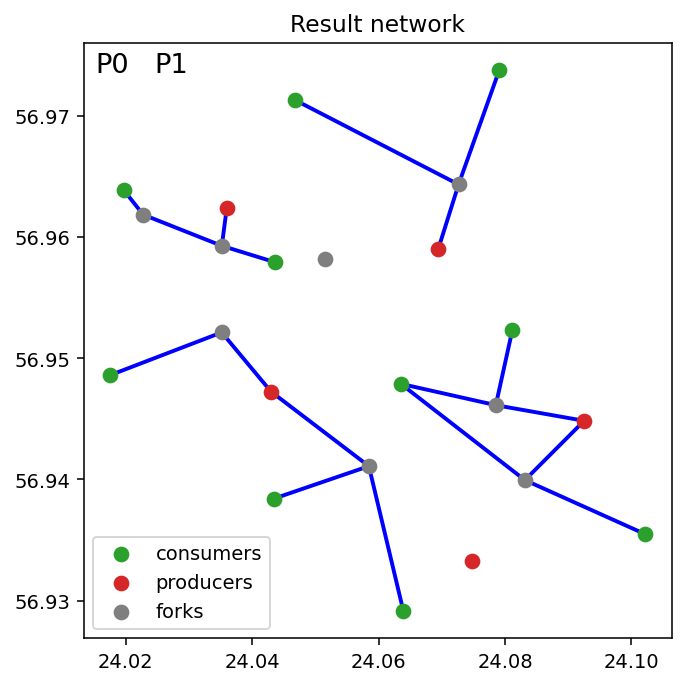

In [180]:
# plot invested edges
plt.rcParams['figure.figsize'] = (10, 8)   # <-- bigger
plt.rcParams['figure.dpi'] = 140

static_map_2 = dhnx.plotting.StaticMap(twn_results)
static_map_2.draw(background_map=False)
ax = plt.gca()
ax.set_title('Result network')

# Scatter points
plt.scatter(network.components.consumers['lon'], network.components.consumers['lat'],
            color='tab:green', label='consumers', zorder=2.5, s=50)
plt.scatter(network.components.producers['lon'], network.components.producers['lat'],
            color='tab:red', label='producers', zorder=2.5, s=50)
plt.scatter(network.components.forks['lon'], network.components.forks['lat'],
            color='tab:grey', label='forks', zorder=2.5, s=50)

# labels that DON'T expand the axis extent
plt.text(0.02, 0.95, 'P0', transform=ax.transAxes, fontsize=14)
plt.text(0.12, 0.95, 'P1', transform=ax.transAxes, fontsize=14)

plt.legend()
plt.tight_layout()
plt.show()